In [1]:
# import some useful package
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

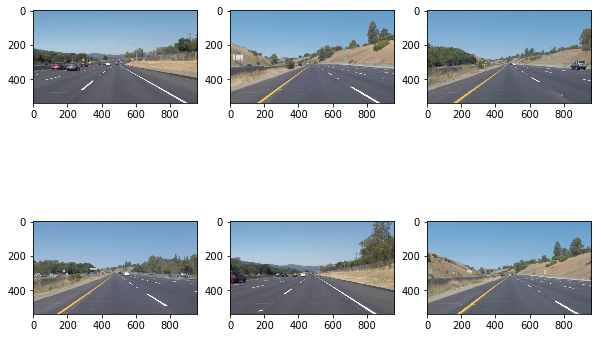

In [2]:
#displace image #可以用一个def来管理
def show_images(images,cmap=None):
    cols=3
    rows=(len(images)+1)//2
    plt.figure(figsize=(10,11))
    for i,image in enumerate(images):
        plt.subplot(cols,rows,i+1)
        plt.imshow(image,cmap=cmap)
#load image
init_images=[plt.imread(path) for path in glob.glob(
    '/home/wuying/study/udacity/CarND-LaneLines-P1-master/test_images/*.jpg')]
# plt.imshow(init_images)
show_images(init_images)

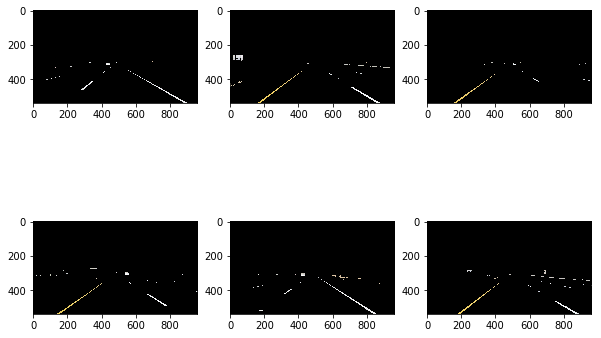

In [3]:
#color selection white and yellow
def color_select(image):
    white_threshold_lower=np.uint8([200,200,200])
    white_threshold_upper=np.uint8([255,255,255])
    white_mask=cv2.inRange(image,white_threshold_lower,white_threshold_upper)
    
    yellow_threshold_lower=np.uint8([190,190,0])
    yellow_threshold_upper=np.uint8([255,255,204])
    yellow_mask=cv2.inRange(image,yellow_threshold_lower,yellow_threshold_upper)
    
    mask=cv2.bitwise_or(white_mask,yellow_mask)
    masked=cv2.bitwise_and(image,image,mask=mask)
    
    return masked
color_select_images=list(map(color_select,init_images))
show_images(color_select_images)

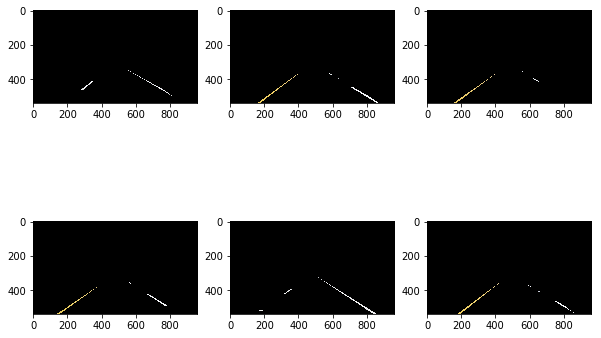

In [4]:
#roi
def filter_region(image,vertices):
    
    mask = np.zeros_like(image)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input ima
    if len(image.shape) > 2:
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image
    
def vertices(image):
    rows,cols=image.shape[:2]
    bottom_left=[cols*0.1,rows]
    bottom_right=[cols*0.5,rows*0.6]
    top_left=[cols*0.9,rows]
    top_right=[cols*0.6,rows*0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return filter_region(image, vertices)
    
ROI_images=list(map(vertices,color_select_images))
show_images(ROI_images)

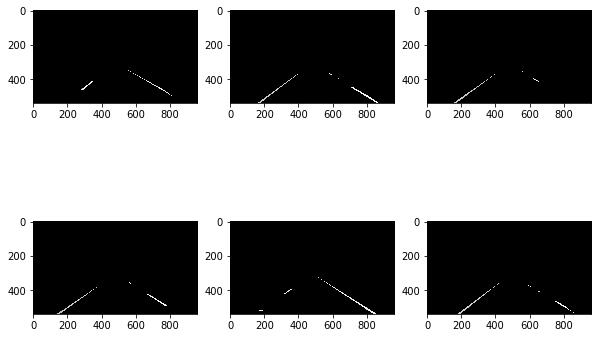

In [5]:

#grayscale
def grayscale(images):
    return cv2.cvtColor(images, cv2.COLOR_RGB2GRAY)

gray_images=list(map(grayscale,ROI_images))
show_images(gray_images,cmap='gray')

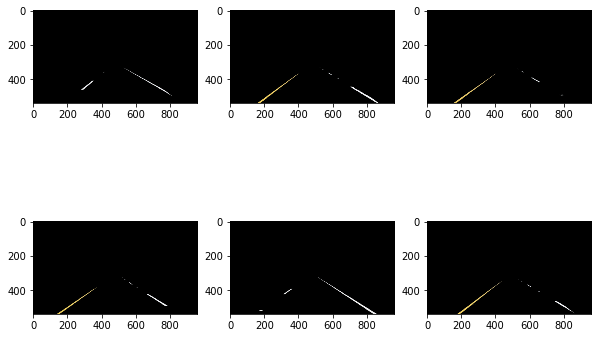

In [6]:
#Gaussian smoothing
def Gaussian_smoothing(images,kernel_size=5):
    return cv2.GaussianBlur(images,(kernel_size,kernel_size),0)
Gaussian_images=list(map(Gaussian_smoothing,ROI_images))
show_images(Gaussian_images)

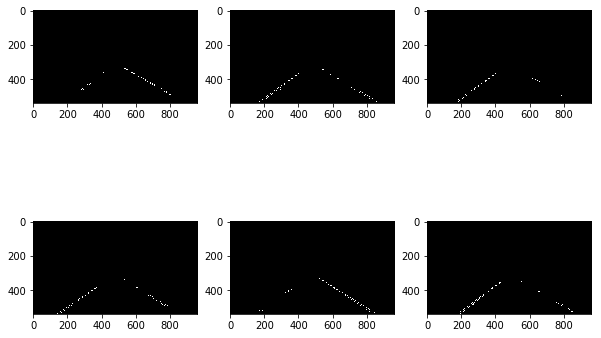

In [7]:
#canny
def canny(image,low_threshold=50, high_threshold=150):
    return cv2.Canny(image,low_threshold,high_threshold)

canny_edge_image=list(map(canny,Gaussian_images))
show_images(canny_edge_image,cmap='gray')

In [8]:
#hough transform
def hough_transform(images):
    return cv2.HoughLinesP(images, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)

lines_images=list(map(hough_transform,canny_edge_image))

In [9]:
# #draw lines
# def draw_lines(images,lines,color=[255,0,0],thickness=2,make_copy=True):
#     if make_copy:
#         images=np.copy(images)
#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             cv2.line(image, (x1, y1), (x2, y2), color, thickness)

#     return images
# line_images=[] 
# for image,lines in zip(init_images,lines_images):
#     line_images.append(draw_lines(images,lines))
# show_images(line_images)

In [10]:
def average_slope_and_intercept(lines):
    left_lines=[]# left_slope and left_intercept
    left_length=[]#left_lines_lengt
    right_lines=[]
    right_length=[]
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope=(y2-y1)/(x2-x1)
            intercept=y2-x2*slope
            length=np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope>0:
                right_lines.append((slope,intercept))
                right_length.append(length)
            else:
                left_lines.append((slope,intercept))
                left_length.append(length)
    left_lane  = np.dot(left_length,  left_lines) /np.sum(left_length)  if len(left_length) >0 else None
    right_lane = np.dot(right_length, right_lines)/np.sum(right_length) if len(right_length)>0 else None
    
    return left_lane, right_lane # (slope, intercept), (slope, intercept)

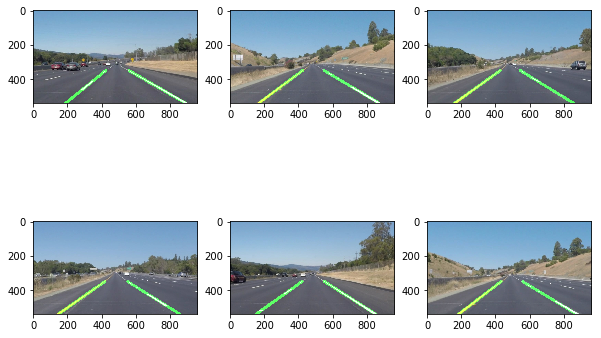

In [11]:
#draw whole lines 
def draw_whole_lines_endpoints(y1,y2,line):
    
    if line is None:
        return None
    
    slope, intercept = line
    x1 = int((y1 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    x2 = int((y2 - intercept)/slope)
    return ((x1,y1),(x2,y2))

def lane_lines(image,lines):
    left_lane, right_lane = average_slope_and_intercept(lines)
    
    y1 = image.shape[0] # bottom of the image
    y2 = y1*0.65        # slightly lower than the middle

    left_line  = draw_whole_lines_endpoints(y1, y2, left_lane)
    right_line = draw_whole_lines_endpoints(y1, y2, right_lane)
    
    return left_line, right_line

def draw_whole_lines(image,lines,color=[0,255,0],thickness=15):
    whole_lines_image=np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(whole_lines_image,*line,  color, thickness)
    return cv2.addWeighted(image, 1.0, whole_lines_image, 0.95, 0.0)

whole_lines_images=[]
for image, lines in zip(init_images, lines_images):
    whole_lines_images.append(draw_whole_lines(image, lane_lines(image,lines)))
show_images(whole_lines_images)

In [12]:
from collections import deque

QUEUE_LENGTH=50

class LaneDetector:
    def __init__(self):
        self.left_lines  = deque(maxlen=QUEUE_LENGTH)
        self.right_lines = deque(maxlen=QUEUE_LENGTH)

    def process(self, image):
        white_yellow = color_select(image)
        regions      = vertices(white_yellow)
        gray         = grayscale(regions)
        smooth_gray  = Gaussian_smoothing(gray)
        edges        = canny(smooth_gray)
        lines        = hough_transform(edges)
        left_line, right_line = lane_lines(image, lines)

        def mean_line(line, lines):
            if line is not None:
                lines.append(line)

            if len(lines)>0:
                line = np.mean(lines, axis=0, dtype=np.int32)
                line = tuple(map(tuple, line)) # make sure it's tuples not numpy array for cv2.line to work
            return line

        left_line  = mean_line(left_line,  self.left_lines)
        right_line = mean_line(right_line, self.right_lines)

        return draw_whole_lines(image, (left_line, right_line))

In [ ]:
from moviepy.editor import VideoFileClip
import os
def process_video(video_input, video_output):
    detector = LaneDetector()
    clip = VideoFileClip(os.path.join('test_videos', video_input))
    processed = clip.fl_image(detector.process)
    processed.write_videofile(os.path.join('output_videos', video_output), audio=False)

In [ ]:
%time process_video('/home/wuying/study/udacity/CarND-LaneLines-P1-master/test_videos/solidWhiteRight.mp4','/home/wuying/study/udacity/CarND-LaneLines-P1-master/test_videos/new/1.mp4')

[MoviePy] >>>> Building video /home/wuying/study/udacity/CarND-LaneLines-P1-master/test_videos/new/1.mp4
[MoviePy] Writing video /home/wuying/study/udacity/CarND-LaneLines-P1-master/test_videos/new/1.mp4


  0%|          | 0/222 [00:00<?, ?it/s]

In [ ]:
%time process_video('/home/wuying/study/udacity/CarND-LaneLines-P1-master/test_videos/solidYellowLeft.mp4','/home/wuying/study/udacity/CarND-LaneLines-P1-master/test_videos/new/2.mp4')

In [ ]:
%time process_video('/home/wuying/study/udacity/CarND-LaneLines-P1-master/test_videos/challenge.mp4','/home/wuying/study/udacity/CarND-LaneLines-P1-master/test_videos/new/3.mp4')